In [1]:
# Por Jose D. Cazares Minjares

In [2]:
import pandas as pd
import requests
import zipfile
from io import BytesIO
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Conexión a la base de datos SQLite
conn = sqlite3.connect('urgencias.db')
cursor = conn.cursor()

# Crear tabla para almacenar los datos de urgencias
cursor.execute('''
CREATE TABLE IF NOT EXISTS urgencias (
    id INTEGER PRIMARY KEY,
    fechaingreso TEXT,
    hora_ingreso TEXT,
    edad INTEGER,
    sexo TEXT,
    derhab TEXT,
    tipourgencia TEXT,
    fechaalta TEXT,
    hora_alta TEXT,
    entresidencia INTEGER
)
''')

conn.commit()

In [21]:
# URL del archivo .zip en la página web
url = 'http://www.dgis.salud.gob.mx/descargas/datosabiertos/urgencias/Urgencias_2023.zip?v=2024.05.06'

# Descargar el archivo .zip
response = requests.get(url)

# Diccionarios de mapeo para las columnas especificadas
sexo_mapping = {1: 'HOMBRE', 2: 'MUJER'}
derhab_mapping = {
    0: 'NO ESPECIFICADO', 1: 'NINGUNA', 2: 'IMSS', 3: 'ISSSTE', 4: 'PEMEX',
    5: 'SEDENA', 6: 'SEMAR', 8: 'OTRA', 10: 'IMSS BIENESTAR', 11: 'ISSFAM',
    13: 'INSABI', 'G': 'GRATUIDAD'
}
tipourgencia_mapping = {
    1: 'URGENCIA CALIFICADA', 2: 'URGENCIA NO CALIFICADA', 9: 'NO ESPECIFICADO'
}

# Extraer el contenido del archivo .zip y trabajar con los archivos dentro de él
with zipfile.ZipFile(BytesIO(response.content)) as z:
    # Obtener la lista de archivos dentro del .zip
    file_list = z.namelist()
    print("Archivos en el .zip:")
    for file_name in file_list:
        print(file_name)
    
    # Suponiendo que el archivo que deseas leer se llama 'Registros/Urgencias.txt'
    file_to_read = 'Registros/Urgencias.txt'
    if file_to_read in file_list:
        with z.open(file_to_read) as f:
            # Leer el archivo TXT usando Pandas con el delimitador '|'
            df = pd.read_csv(f, delimiter='|')  # Delimitador cambiado a '|'
            
            # Seleccionar solo las columnas necesarias
            df = df[['fechaingreso', 'hora_ingreso', 'EDAD', 'SEXO', 'DERHAB', 
                     'TIPOURGENCIA', 'fechaalta', 'hora_alta', 'ENTRESIDENCIA']]
            
            # Mapear los valores de las columnas especificadas
            df['SEXO'] = df['SEXO'].map(sexo_mapping)
            df['DERHAB'] = df['DERHAB'].map(derhab_mapping)
            df['TIPOURGENCIA'] = df['TIPOURGENCIA'].map(tipourgencia_mapping)
            
            # Filtrar por ENTRESIDENCIA igual a 26
            df = df[df['ENTRESIDENCIA'] == 26]
            
            # Convertir la columna 'fechaingreso' a tipo datetime y establecerla como índice
            df['fechaingreso'] = pd.to_datetime(df['fechaingreso'])
            df.set_index('fechaingreso', inplace=True)
            
            # Reiniciar el índice para que la columna 'fechaingreso' permanezca como una columna
            df.reset_index(inplace=True)
            
            # Mostrar las primeras y las ultimas filas del DataFrame después del formato
            print("Primeras filas del DataFrame después del formato:")
            print(df.head())
            print("Ultimas filas del DataFrame después del formato:")
            print(df.tail())
            
            # Insertar los datos en la base de datos SQLite
            conn = sqlite3.connect('urgencias.db')
            df.to_sql('urgencias', conn, if_exists='append', index=False)
            
    else:
        print(f"El archivo {file_to_read} no se encuentra en el .zip")

Archivos en el .zip:
Registros/Afecciones.txt
Registros/Medicamentos.txt
Registros/Procedimientos.txt
Registros/Urgencias.txt


<ipython-input-21-cacff35beaec>:31: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, delimiter='|')  # Delimitador cambiado a '|'


Primeras filas del DataFrame después del formato:
  fechaingreso hora_ingreso  EDAD    SEXO           DERHAB  \
0   2023-07-12        13:00    46   MUJER           INSABI   
1   2023-07-17        21:14    53   MUJER  NO ESPECIFICADO   
2   2023-08-06        17:41     6   MUJER          NINGUNA   
3   2023-08-14        15:56    62   MUJER             IMSS   
4   2023-01-20        14:38     2  HOMBRE          NINGUNA   

             TIPOURGENCIA   fechaalta hora_alta  ENTRESIDENCIA  
0  URGENCIA NO CALIFICADA  2023-07-12     13:20             26  
1  URGENCIA NO CALIFICADA  2023-07-17     22:14             26  
2     URGENCIA CALIFICADA  2023-08-06     19:37             26  
3     URGENCIA CALIFICADA  2023-08-14     17:15             26  
4     URGENCIA CALIFICADA  2023-01-20     15:52             26  
Ultimas filas del DataFrame después del formato:
       fechaingreso hora_ingreso  EDAD    SEXO           DERHAB  \
193254   2023-04-19        16:00    47   MUJER  NO ESPECIFICADO   
1932

In [37]:
query = "SELECT sexo, COUNT(*) as cantidad FROM urgencias GROUP BY sexo"
df_sexo = pd.read_sql_query(query, conn)
print(df_sexo)

     sexo  cantidad
0    None       220
1  HOMBRE    394875
2   MUJER    571200


In [38]:
query = "SELECT tipourgencia, AVG(edad) as edad_promedio FROM urgencias GROUP BY tipourgencia"
df_edad_promedio = pd.read_sql_query(query, conn)
print(df_edad_promedio)

             tipourgencia  edad_promedio
0     URGENCIA CALIFICADA      34.861228
1  URGENCIA NO CALIFICADA      29.955578


In [39]:
query = """
SELECT strftime('%Y-%m', fechaingreso) as mes, COUNT(*) as cantidad 
FROM urgencias 
GROUP BY mes
"""
df_urgencias_mes = pd.read_sql_query(query, conn)
print(df_urgencias_mes)

        mes  cantidad
0   2022-12       190
1   2023-01     69915
2   2023-02     64260
3   2023-03     77175
4   2023-04     71185
5   2023-05     81460
6   2023-06     83695
7   2023-07     85715
8   2023-08     86590
9   2023-09     91030
10  2023-10     86950
11  2023-11     84500
12  2023-12     83630


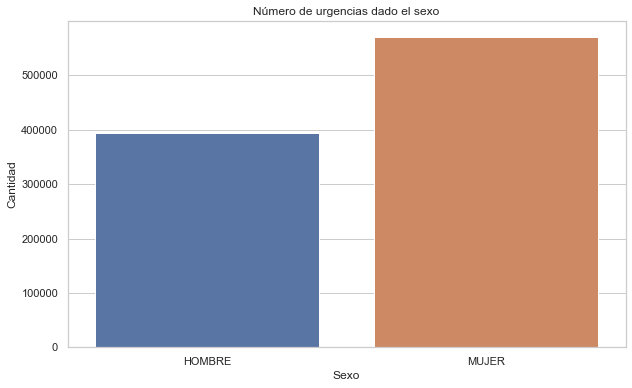

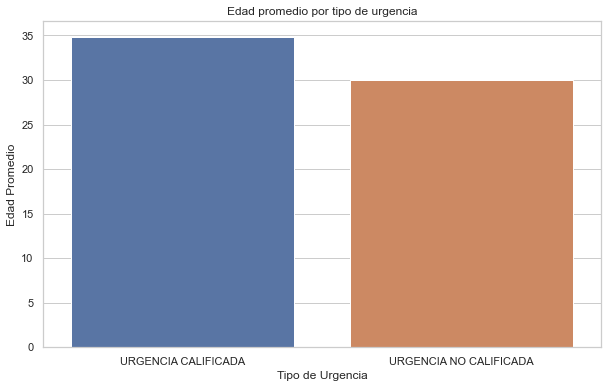

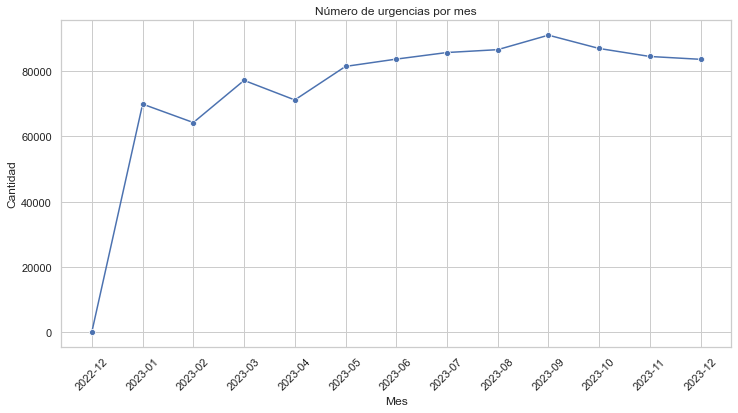

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para seaborn
sns.set(style="whitegrid")

# Gráfico de barras del número de registros por sexo
plt.figure(figsize=(10, 6))
sns.barplot(x='sexo', y='cantidad', data=df_sexo)
plt.title('Número de urgencias dado el sexo')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')
plt.show()

# Gráfico de barras de la edad promedio por tipo de urgencia
plt.figure(figsize=(10, 6))
sns.barplot(x='tipourgencia', y='edad_promedio', data=df_edad_promedio)
plt.title('Edad promedio por tipo de urgencia')
plt.xlabel('Tipo de Urgencia')
plt.ylabel('Edad Promedio')
plt.show()

# Gráfico de líneas del número de urgencias por mes
plt.figure(figsize=(12, 6))
sns.lineplot(x='mes', y='cantidad', data=df_urgencias_mes, marker='o')
plt.title('Número de urgencias por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

In [52]:
# Definir la consulta SQL
query = """
SELECT SEXO, TIPOURGENCIA, COUNT(*) AS cantidad
FROM urgencias
GROUP BY SEXO, TIPOURGENCIA;
"""

# Ejecutar la consulta y almacenar el resultado en un DataFrame de Pandas
result = pd.read_sql_query(query, conn)

# Mostrar el resultado
print(result)

# Cerrar la conexión a la base de datos
conn.close()

     sexo            tipourgencia  cantidad
0    None     URGENCIA CALIFICADA        65
1    None  URGENCIA NO CALIFICADA       155
2  HOMBRE     URGENCIA CALIFICADA    130310
3  HOMBRE  URGENCIA NO CALIFICADA    264565
4   MUJER     URGENCIA CALIFICADA    136610
5   MUJER  URGENCIA NO CALIFICADA    434590


In [ ]:
# Algo que podemos observar es que las mujer son mas suseptibles a tener una urgencia, y tambien el numero de urgencias no
# calificadas es mucho mayor para este genero, podemos intuir que pueden solicitar servicios de emergencias por cuestiones
# menores o por que su numero emergencias registrado es mayor la proabiliadad de este suceso es mayor.

In [41]:
#Cierre de la conexión
conn.close()